# Bank Telemarketing Analysis

# Table of Contents

1. **[Project Background](#1)**
2. **[Data Cleaning](#2)**
3. **[Exploratory Data Analysis](#3)**
4. **[Data Visualization](#4)**
5. **[Machine Learning: Classification](#5)**
6. **[Machine Learning: Regression](#6)**
7. **[Conclusion & Recommendations](#7)**

# Part 1. Project Background

Nowadays, marketing spending in the banking industry is massive, meaning that it is essential for banks to optimize marketing strategies and improve effectiveness. Understanding customers’ need leads to more effective marketing plans, smarter product designs and greater customer satisfaction.

### Main Objective: increase the effectiveness of the bank's telemarketing campaign
This project will enable the bank to develop a more granular understanding of its customer base, predict customers' response to its telemarketing campaign and establish a target customer profile for future marketing plans.

By analyzing customer features, such as demographics and transaction history, the bank will be able to predict customer saving behaviours and identify which type of customers is more likely to make term deposits. The bank can then focus its marketing efforts on those customers. This will not only allow the bank to secure deposits more effectively but also increase customer satisfaction by reducing undesirable advertisements for certain customers.

## Load the raw data

This dataset is about the direct phone call marketing campaigns, which aim to promote term deposits among existing customers, by a Portuguese banking institution from May 2008 to November 2010. It is publicly available in the UCI Machine learning Repository, which can be retrieved from http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#.

In [448]:
import pandas as pd
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os

dataset1 = pd.read_csv('bank-full.csv', sep = ';')

There are 41,188 observations in this dataset. Each represents an existing customer that the bank reached via phone calls.
* For each observation, the dataset records **16 input variables** that stand for both qualitative and quantitative attributes of the customer, such as age, job, housing and personal loan status, account balance, and the number of contacts.
* There is **a single binary output variable** that denotes “yes” or “no” revealing the outcomes of the phone calls.

In [449]:
# View the first 5 rows in the dataset
dataset1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Clean the dataset

### 2.1 Deal with missing data

There is no missing value in this dataset. Nevertheless, there are values like “unknown”, “others”, which are helpless just like missing values. Thus, these ambiguous values are removed from the dataset.

In [450]:
# Step 1: Delete the rows which column 'poutcome' contains 'other'
condition = dataset1.poutcome == 'other'
dataset2 = dataset1.drop(dataset1[condition].index, axis = 0, inplace = False)

In [451]:
# Step 2: Replace 'unknown' in job and education with 'other'
dataset2[['job','education']] = dataset2[['job','education']].replace(['unknown'],'other')

### 2.2 Drop outliers in the column 'balance'

In order to capture the general trend in the dataset, outliers in the column “balance” are dropped. Outliers are defined as the values which are more than three standard deviations away from the mean.
In sum, 2556 rows of data were removed.

In [452]:
from scipy.stats import zscore

dataset2[['balance']].mean()
dataset2[['balance']].mean()

dataset2['balance_outliers'] = dataset2['balance']
dataset2['balance_outliers']= zscore(dataset2['balance_outliers'])

condition1 = (dataset2['balance_outliers']>3) | (dataset2['balance_outliers']<-3 )
dataset3 = dataset2.drop(dataset2[condition1].index, axis = 0, inplace = False)

In [453]:
dataset4 = dataset3.drop('balance_outliers', axis=1)

### 2.3 Creating and transforming data

Some changes were made to the column name, units and data types for easier analysis.

In [454]:
# Step 1: Change column name: 'y' to 'response'
dataset4.rename(index=str, columns={'y': 'response'}, inplace = True)

def convert(dataset4, new_column, old_column):
    dataset4[new_column] = dataset4[old_column].apply(lambda x: 0 if x == 'no' else 1)
    return dataset4[new_column].value_counts()

convert(dataset4, "response_binary", "response")

response_binary
0    37785
1     4870
Name: count, dtype: int64

In [455]:
# Step 2: Drop column "contact" which is useless
dataset5 = dataset4.drop('contact', axis=1)

In [456]:
# Step 3: Change the unit of 'duration' from seconds to minutes
dataset5['duration'] = dataset5['duration'].apply(lambda n:n/60).round(2)

In [457]:
# Step 4: Change 'month' from words to numbers for easier analysis
lst = [dataset5]
for column in lst:
    column.loc[column["month"] == "jan", "month_int"] = 1
    column.loc[column["month"] == "feb", "month_int"] = 2
    column.loc[column["month"] == "mar", "month_int"] = 3
    column.loc[column["month"] == "apr", "month_int"] = 4
    column.loc[column["month"] == "may", "month_int"] = 5
    column.loc[column["month"] == "jun", "month_int"] = 6
    column.loc[column["month"] == "jul", "month_int"] = 7
    column.loc[column["month"] == "aug", "month_int"] = 8
    column.loc[column["month"] == "sep", "month_int"] = 9
    column.loc[column["month"] == "oct", "month_int"] = 10
    column.loc[column["month"] == "nov", "month_int"] = 11
    column.loc[column["month"] == "dec", "month_int"] = 12

### 2.4 Filtering

In [458]:
# Step 1: Drop rows that 'duration' < 5s
condition2 = (dataset5['duration']<5/60)
dataset6 = dataset5.drop(dataset5[condition2].index, axis = 0, inplace = False)

In [459]:
# Step 2: Drop customer values with 'other' education
condition3 = (dataset6['education'] == 'other')
dataset7 = dataset6.drop(dataset6[condition3].index, axis = 0, inplace = False)

# Part 3. Exploratory Data Analysis <a id="3"></a>

To obtain a better understanding of the dataset, the distribution of key variables and the relationships among them were plotted.

### 3.1 Visualize the distribution of 'age' and 'balance'

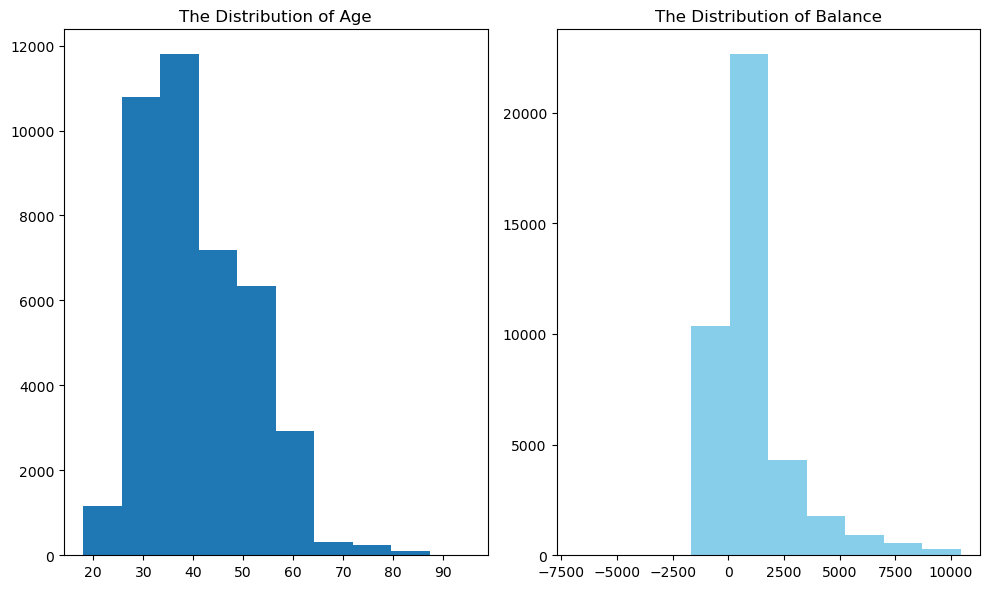

In [460]:
dist_age_balance = plt.figure(figsize = (10,6))

ra1 = dist_age_balance.add_subplot(1,2,1)
ra2 = dist_age_balance.add_subplot(1,2,2)

ra1.hist(dataset7['age'])
ra1.set_title('The Distribution of Age')

ra2.hist(dataset7['balance'], color = 'skyblue')
ra2.set_title('The Distribution of Balance')

plt.tight_layout()
plt.show()

**The distribution of age**: In its telemarketing campaigns, clients called by the bank have an extensive age range, from 18 to 95 years old. However, a majority of customers called is in the age of 30s and 40s (33 to 48 years old fall within the 25th to 75th percentiles). The distribution of customer age is fairly normal with a small standard deviation.

**The distribution of balance**: After dropping outliers in balance, the range of balance is still massive, from a minimum of -6847 to a maximum of 10443 euros, giving a range of 17290 euros. The distribution of balance has a huge standard deviation relative to the mean, suggesting large variabilities in customers' balance levels.

### 3.2 Visualize the relationship between 'age' and 'balance'

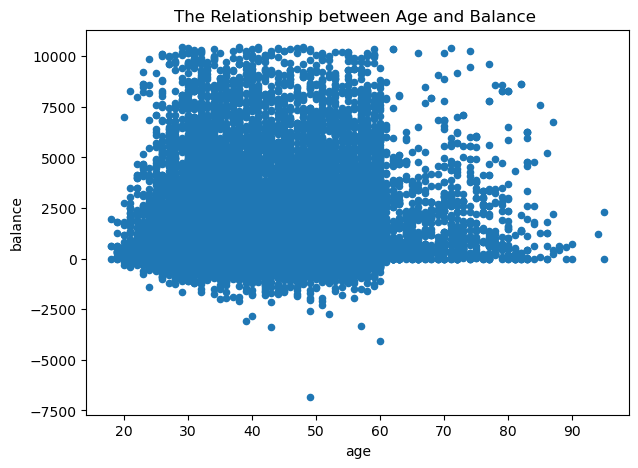

In [461]:
scatter_age_balance = dataset7.plot.scatter('age','balance',figsize = (7,5))

plt.title('The Relationship between Age and Balance ')
plt.show()

Based on this scatter plot, there is no clear relationship between client’s age and balance level.

Nevertheless, over the age of 60, clients tend to have a significantly lower balance, mostly under 5,000 euros. This is due to the fact that most people retire after 60 and no longer have a reliable income source.

### 3.3 Visualize the distribution of 'duration' & 'campaign'

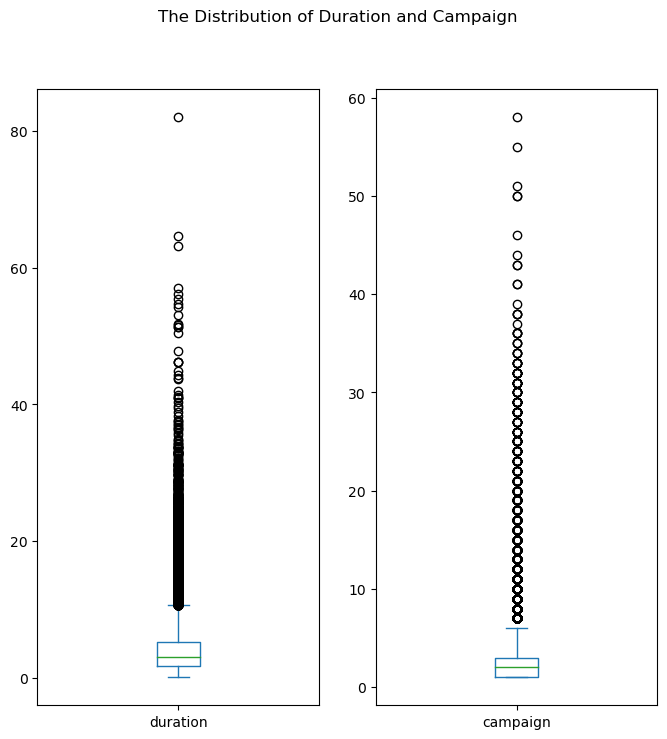

In [462]:
dist_dur_cam = dataset7[['duration','campaign']].plot(kind = 'box',
                                                      figsize = (8,8),
                                                      subplots = True, layout = (1,2),
                                                      sharex = False, sharey = False,
                                                      title='The Distribution of Duration and Campaign')
plt.show()

**The distribution of duration**: As observed from the box plot, the duration of contact has a median of 3 minutes, with an interquartile range of 1.73 minutes to 5.3 minutes. The left-skewed boxplot indicates that most calls are relatively short. Also, there is a large number of outliers ranging from 10 minutes to 40 minutes, which are worth further study.

**The distribution of campagin**: About half of the clients have been contacted by the bank for the second time, while 25% was first introduced to the term deposit. Most clients have been reached by the bank for one to three times, which is reasonable. However, some clients have been contacted by as high as 58 times, which is not normal. These clients may have some special needs that require frequent contact.

### 3.4 Visualize the relationship between 'duration' & 'campaign': with response result

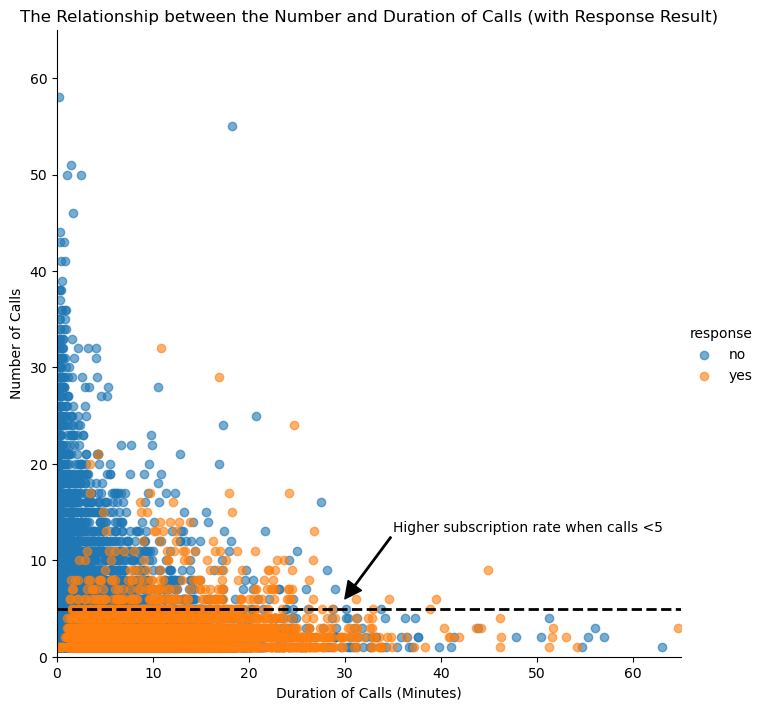

In [463]:
import seaborn as sns
dur_cam = sns.lmplot(x='duration', y='campaign',data = dataset7,
                     hue = 'response',
                     fit_reg = False,
                     scatter_kws={'alpha':0.6}, height =7)

plt.axis([0,65,0,65])
plt.ylabel('Number of Calls')
plt.xlabel('Duration of Calls (Minutes)')
plt.title('The Relationship between the Number and Duration of Calls (with Response Result)')

# Annotation
plt.axhline(y=5, linewidth=2, color="k", linestyle='--')
plt.annotate('Higher subscription rate when calls <5',xytext = (35,13),
             arrowprops=dict(color = 'k', width=1),xy=(30,6))
plt.show()

In this scatter plot, clients subscribed to term deposits are denoted as "yes" while those did not are denoted as "no".

As we can see from the plot, “yes” clients and “no” clients are forming two relatively separate clusters. Compared to “no” clients”, “yes” clients were contacted by fewer times and had longer call duration. More importantly, after five campaign calls, clients are more likely to reject the term deposit unless the duration is high. Most “yes” clients were approached by less than 10 times.

This suggests that the bank should resist calling a client for more than five times, which can be disturbing and increase dissatisfaction.

### 3.5 Scatter matrix and Correlation matrix

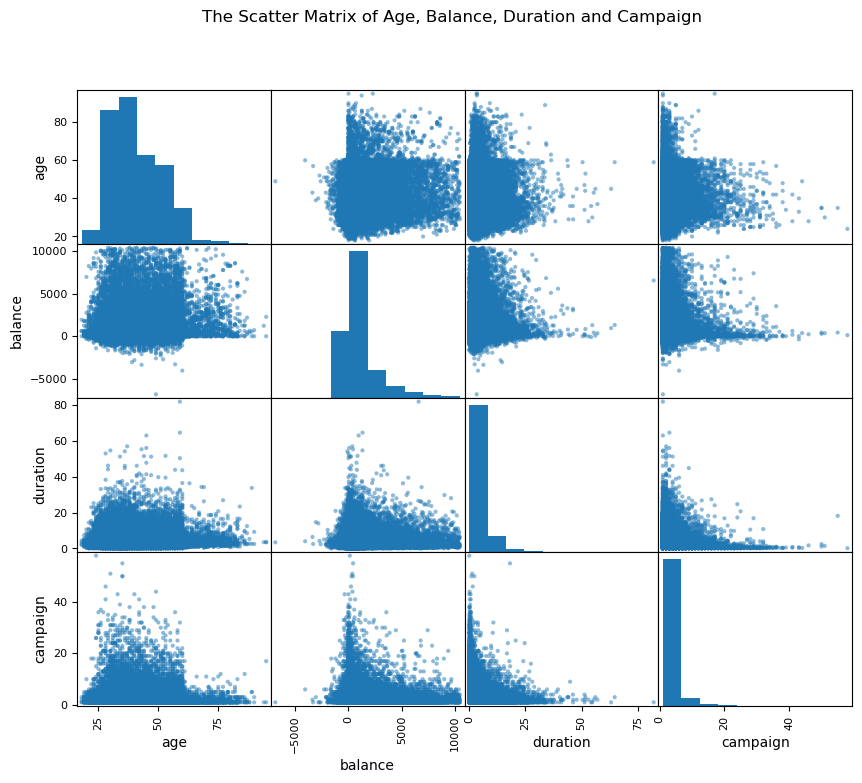

In [464]:
from pandas.plotting import scatter_matrix
matrix = scatter_matrix(dataset7[['age','balance','duration','campaign']],figsize=(10,8))

plt.suptitle('The Scatter Matrix of Age, Balance, Duration and Campaign')
plt.show()

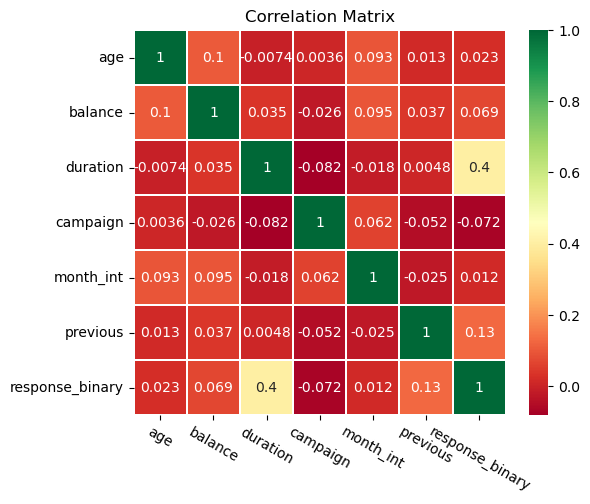

In [465]:
corr_data = dataset7[['age','balance','duration','campaign','month_int','previous','response_binary']]
corr = corr_data.corr()

cor_plot = sns.heatmap(corr,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.xticks(fontsize=10,rotation=-30)
plt.yticks(fontsize=10)
plt.title('Correlation Matrix')
plt.show()

The scatter matrix does not reveal any clear relationship among age, balance, duration and campaign.

To investigate more about correlation, a correlation matrix was plotted with all qualitative variables. Clearly, “campaign outcome” has a strong correlation with “duration”, a moderate correlation with “previous contacts”, and mild correlations between “balance”, “month of contact” and “number of campaign”. Their influences on campaign outcome will be investigated further in the machine learning part.

# Part 4. Data Visualization <a id="4"></a>

With a sound knowledge of the distribution of key variables, further analysis of each customer characteristic can be carried out to investigate its influence on the subscription rate.

### 4.1 Visualize the subscription and contact rate by age

In [466]:
lst = [dataset7]
for column in lst:
    column.loc[column["age"] < 30,  'age_group'] = 20
    column.loc[(column["age"] >= 30) & (column["age"] <= 39), 'age_group'] = 30
    column.loc[(column["age"] >= 40) & (column["age"] <= 49), 'age_group'] = 40
    column.loc[(column["age"] >= 50) & (column["age"] <= 59), 'age_group'] = 50
    column.loc[column["age"] >= 60, 'age_group'] = 60

In [467]:
count_age_response_pct = pd.crosstab(dataset7['response'],dataset7['age_group']).apply(lambda x: x/x.sum() * 100)
count_age_response_pct = count_age_response_pct.transpose()

In [468]:
age = pd.DataFrame(dataset7['age_group'].value_counts())
age.reset_index(inplace = True)
age['% Contacted'] = age['age_group']*100/age['age_group'].sum()
age['% Subscription'] = count_age_response_pct['yes']
age.drop('age_group',axis = 1,inplace = True)

age['age'] = [30,40,50,20,60]
age = age.sort_values('age',ascending = True)

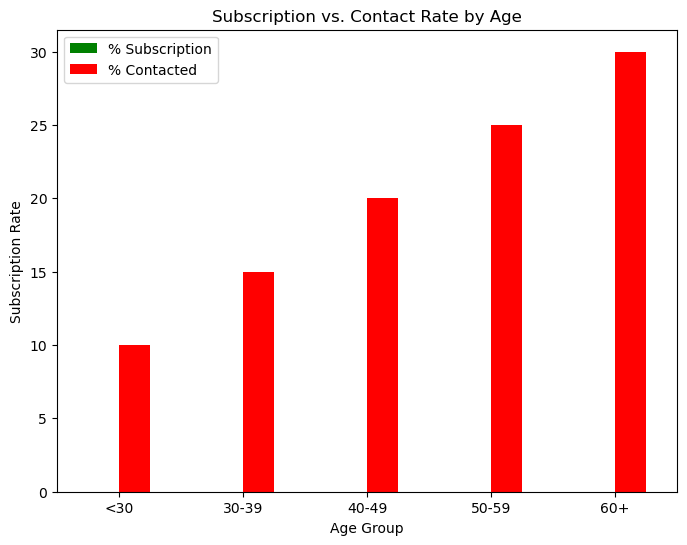

In [469]:
plot_age = age[['% Subscription','% Contacted']].plot(kind = 'bar',
                                              figsize=(8,6), color = ('green','red'))
plt.xlabel('Age Group')
plt.ylabel('Subscription Rate')
plt.xticks(np.arange(5), ('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')
plt.title('Subscription vs. Contact Rate by Age')
plt.show()

**Insights: target the youngest and the oldest instead of the middle-aged**

Green vertical bars indicate that clients with a age of 60+ have the highest subscription rate. About 17% of the subscriptions came from the clients aged between 18 to 29. More than 50% of the subscriptions are contributed by the youngest and the eldest clients.

* It is not surprising to see such a pattern because the main investment objective of older people is saving for retirement while the middle-aged group tend to be more aggressive with a main objective of generating high investment income. Term deposits, as the least risky investment tool, are more preferable to the eldest.


* The youngest may not have enough money or professional knowledge to engage in sophisticated investments, such as stocks and mutual funds. Term deposits provide liquidity and generate interest incomes that are higher than the regular saving account, so term deposits are ideal investments for students.

However, red vertical bars show that the bank focused its marketing efforts on the middle-aged group, which returned lower subscription rates than the younger and older groups. Thus, to make the marketing campaign more effective, the bank should target younger and older clients in the future.

### 4.2 Visualize the subscription rate by balance level

In [470]:
lst = [dataset7]
for column in lst:
    column.loc[column["balance"] <= 0,  'balance_group'] = 'no balance'
    column.loc[(column["balance"] > 0) & (column["balance"] <= 1000), 'balance_group'] = 'low balance'
    column.loc[(column["balance"] > 1000) & (column["balance"] <= 5000), 'balance_group'] = 'average balance'
    column.loc[(column["balance"] > 5000), 'balance_group'] = 'high balance'

In [471]:
count_balance_response_pct = pd.crosstab(dataset7['response'],dataset7['balance_group']).apply(lambda x: x/x.sum() * 100)
count_balance_response_pct = count_balance_response_pct.transpose()

In [472]:
bal = pd.DataFrame(dataset7['balance_group'].value_counts())

bal['% Contacted'] = bal['count']*100/bal['count'].sum()
bal['% Subscription'] = count_balance_response_pct['yes']
bal.reset_index(inplace=True)
bal.drop('balance_group',axis = 1,inplace = True)

bal['bal'] = [1,2,0,3]
bal = bal.sort_values('bal',ascending = True)


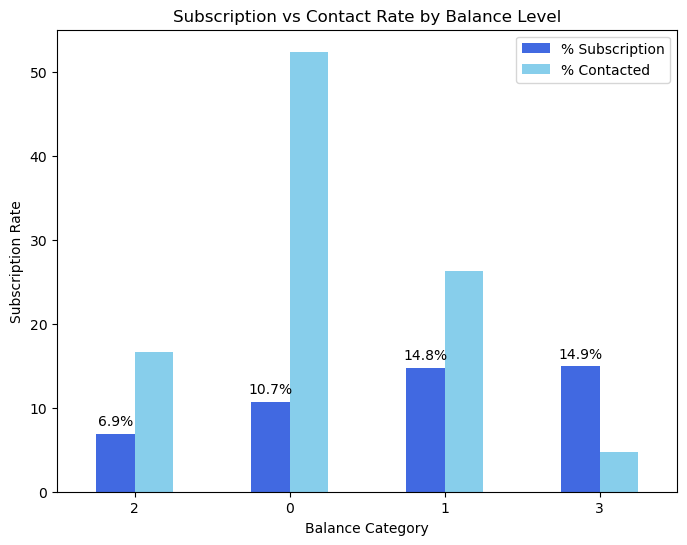

In [473]:
plot_balance = bal[['% Subscription','% Contacted']].plot(kind = 'bar',
                                               color = ('royalblue','skyblue'),
                                               figsize = (8,6))

plt.title('Subscription vs Contact Rate by Balance Level')
plt.ylabel('Subscription Rate')
plt.xlabel('Balance Category')
plt.xticks(rotation = 'horizontal')

# label the bar
for rec, label in zip(plot_balance.patches,
                      bal['% Subscription'].round(1).astype(str)):
    plot_balance.text(rec.get_x() + rec.get_width()/2,
                      rec.get_height() + 1,
                      label+'%',
                      ha = 'center',
                      color = 'black')

**Insights: target clients with average or high balance**

To identify the trend more easily, clients are categorized into four groups based on their levels of balance:
* No Balance: clients with a negative balance.
* Low Balance: clients with a balance between 0 and 1000 euros
* Average Balance: clients with a balance between 1000 and 5000 euros.
* High Balance: clients with a balance greater than 5000 euros.


Unsurprisingly, this bar chart indicates a positive correlation between clients’ balance levels and subscription rate. Clients with negative balances only returned a subscription rate of 6.9% while clients with average or high balances had significantly higher subscription rates, nearly 15%.

However, in this campaign, more than 50% of clients contacted only have a low balance level. In the future, the bank should shift its marketing focus to high-balance customers to secure more term deposits.

### 4.3 Visualize the subscription rate by age and balance

In [474]:
age_balance1 = pd.DataFrame(dataset7.groupby(['age_group','balance_group'])['response_binary'].sum())
age_balance2 = pd.DataFrame(dataset7.groupby(['age_group','balance_group'])['response'].count())

age_balance1['response'] = age_balance2['response']
age_balance1['response_rate'] = age_balance1['response_binary']/ (age_balance1['response'])
age_balance1 = age_balance1.drop(['response_binary','response'],axis =1)

age_balance1 = age_balance1.unstack()

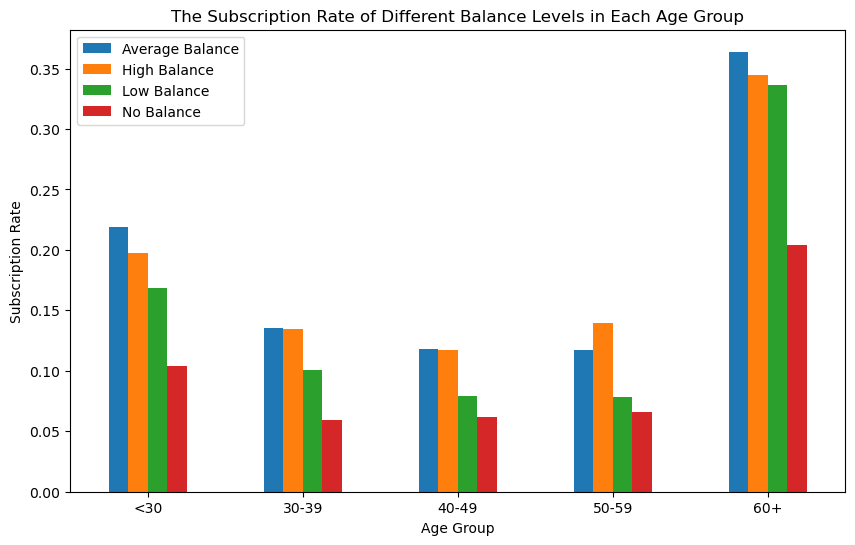

In [475]:
age_bal = age_balance1.plot(kind='bar',figsize = (10,6))

# Set x ticks
plt.xticks(np.arange(5),('<30', '30-39', '40-49', '50-59', '60+'),rotation = 'horizontal')

# Set legend
plt.legend(['Average Balance','High Balance','Low Balance','No Balance'],loc = 'best',ncol = 1)

plt.ylabel('Subscription Rate')
plt.xlabel('Age Group')
plt.title('The Subscription Rate of Different Balance Levels in Each Age Group')
plt.show()

**Insights: target older clients with high balance levels**

While age represents a person’s life stage and balance represents a person’s financial condition, jointly evaluating the impact of these two factors enables us to investigate if there is a common trend across all ages, and to identify which combination of client features indicates the highest likelihood of subscription.

In order to investigate the combined effect of age and balance on a client’s decision, we performed a two-layer grouping, segmenting customers according to their balance levels within each age group.

* The graph tells the same story regarding the subscription rate for different age groups: **the willingness to subscribe is exceptionally high for people aged above 60 and younger people aged below 30** also have a distinguishable higher subscription rate than those of other age groups.


* Furthermore, **the effect of balance levels on subscription decision is applicable to each individual age group**: every age group shares a common trend that the percentage of subscription increases with balance.

In sum, the bank should **prioritize its telemarketing to clients who are above 60 years old and have positive balances**, because they have the highest acceptance rate of about 35%. The next group the bank should focus on is **young clients with positive balances**, who showed high subscription rates between 15% and 20%.

### 4.4 Visualize the subscription rate by job

In [476]:
count_job_response_pct = pd.crosstab(dataset7['response'],dataset7['job']).apply(lambda x: x/x.sum() * 100)
count_job_response_pct = count_job_response_pct.transpose()

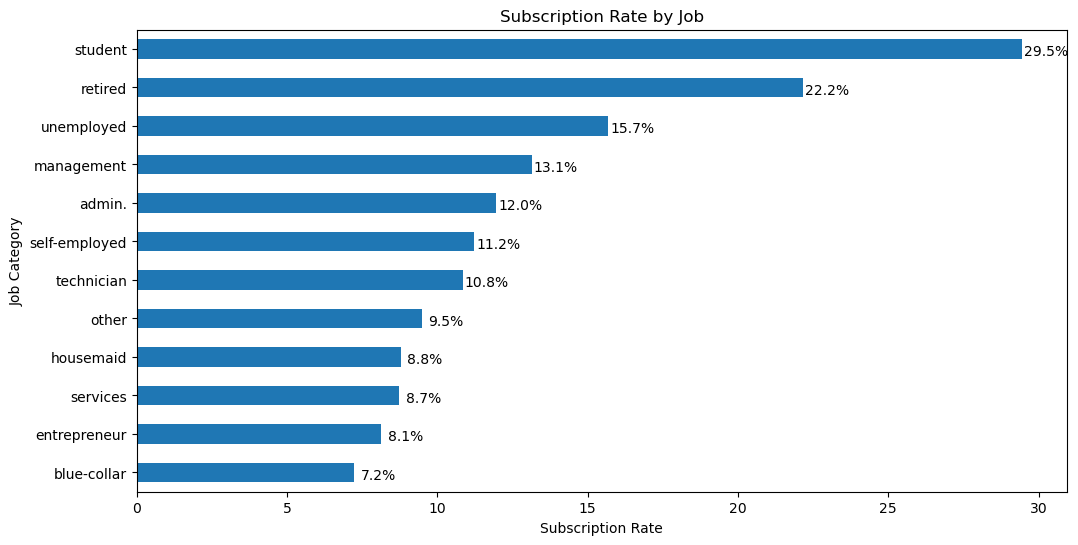

In [477]:
plot_job = count_job_response_pct['yes'].sort_values(ascending = True).plot(kind ='barh',
                                                                           figsize = (12,6))

plt.title('Subscription Rate by Job')
plt.xlabel('Subscription Rate')
plt.ylabel('Job Category')

# Label each bar
for rec, label in zip(plot_job.patches,
                      count_job_response_pct['yes'].sort_values(ascending = True).round(1).astype(str)):
    plot_job.text(rec.get_width()+0.8,
                  rec.get_y()+ rec.get_height()-0.5,
                  label+'%',
                  ha = 'center',
                  va='bottom')

**Insights: target students and retired clients**

As noted from the horizontal bar chart, students and retired clients account for more than 50% of subscription, which is consistent with the previous finding of higher subscription rates among the younger and older.

### 4.5 Visualize the subscription and contact rate by month

In [478]:
count_month_response_pct = pd.crosstab(dataset7['response'],dataset7['month_int']).apply(lambda x: x/x.sum() * 100)
count_month_response_pct = count_month_response_pct.transpose()

In [479]:
month = pd.DataFrame(dataset7['month_int'].value_counts())
month['% Contacted'] = month['count']*100/month['count'].sum()
month['% Subscription'] = count_month_response_pct['yes']
month.reset_index(inplace=True)
month.drop('month_int',axis = 1,inplace = True)

month['Month'] = [5,7,8,6,11,4,2,1,10,9,3,12]
month = month.sort_values('Month',ascending = True)


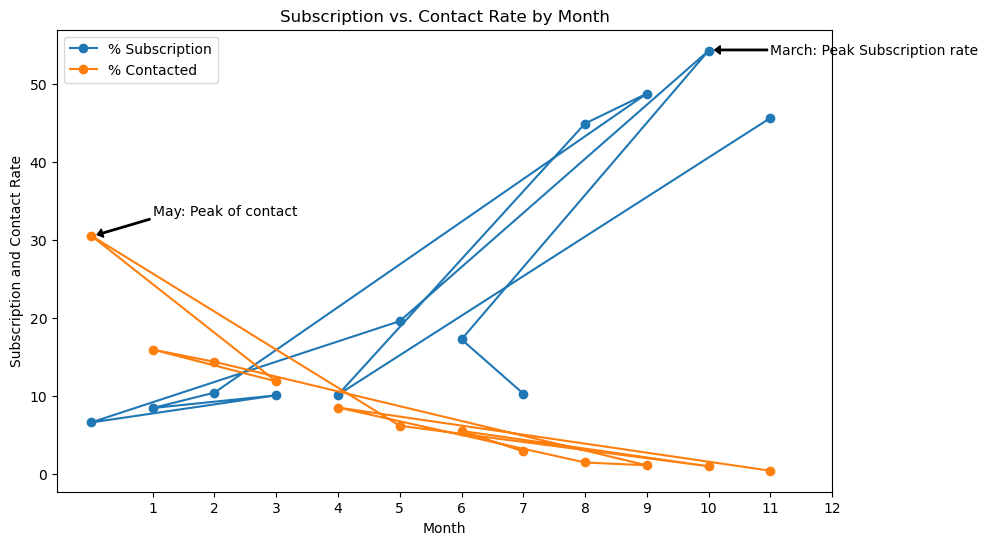

In [480]:
plot_month = month[['% Subscription','% Contacted']].plot(kind ='line',
                                                          figsize = (10,6),
                                                          marker = 'o')

plt.title('Subscription vs. Contact Rate by Month')
plt.ylabel('Subscription and Contact Rate')
plt.xlabel('Month')

ticks = np.arange(1,13,1)
plt.xticks(ticks)

# Annotation: peak of contact
y = month['% Contacted'].max()
x = month['% Contacted'].idxmax()
plt.annotate('May: Peak of contact', xy=(x+0.1, y+0.1), xytext=(x+1,y+4), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

# Annotation: peak of subscription rate
y = month['% Subscription'].max()
x = month['% Subscription'].idxmax()
plt.annotate('March: Peak Subscription rate', xy=(x+0.1, y+0.1), xytext=(x+1,y+1), arrowprops=dict(facecolor='black', headwidth=6, width=1, headlength=4), horizontalalignment='left', verticalalignment='top')

plt.show()

**Insights: initiate the telemarketing campaign in fall or spring**

Besides customer characteristics, external factors may also have an impact on the subscription rate, such as seasons and the time of calling. So the month of contact is also analyzed here.

This line chart displays the bank’s contact rate in each month as well as clients’ response rate in each month. One way to evaluate the effectiveness of the bank's marketing plan is to see whether these two lines have a similar trend over the same time horizon.
* The bank **contacted most clients between May and August**. The highest contact rate is around 30%, which happened in May, while the contact rate is closer to 0 in March, September, October, and December.


* However, the subscription rate showed a different trend. **The highest subscription rate occurred in March**, which is over 50%, and all subscription rates in **September, October, and December** are over 40%.

Clearly, **these two lines move in different directions which strongly indicates the inappropriate timing of the bank’s marketing campaign**. To improve the marketing campaign, the bank should consider initiating the telemarketing campaign in fall and spring when the subscription rate tends to be higher.

Nevertheless, the bank should be cautious when analyzing external factors. More data from previous marketing campaign should be collected and analyzed to make sure that this seasonal effect is constant over time and applicable to the future.


# Part 5. Machine Learning: Classification

The main objective of this project is to identify the most responsive customers before the marketing campaign so that the bank will be able to efficiently reach out to them, saving time and marketing resources. To achieve this objective, classification algorithms will be employed. By analyzing customer statistics, a classification model will be built to classify all clients into two groups: "yes" to term deposits and "no" to term deposits.

## Load the cleaned dataset

In [481]:
dataset = pd.read_csv('bank-full.csv',sep=';')
dataset.head()
dataset = dataset.drop(['contact'], axis=1)

In [482]:
# View the first 5 rows of cleaned data
dataset.head()

,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,5,may,198,1,-1,0,unknown,no


## Prepare Data for Classification

### 5.1 Select variables relevant to customers

Only the most relevant customer information is considered, which includes job title, education, age, balance, default record, housing record and loan record. Other information, such as ‘the number of contacts performed before this campaign’, is omitted because it is not directly related to customers themselves.

In [483]:
dataset.drop(['marital'],axis=1, inplace=True)
dataset1 = dataset.iloc[:, 0:7]
dataset = dataset.rename(columns={'y':'response'})

### 5.2 Tranform categorical data into dummy variables

Since machine learning algorithms only take numerical values, all five categorical variables (job, education, default, housing and loan) are transformed into dummy variables.

Dummy variables were used instead of continuous integers because these categorical variables are not ordinal. They simply represent different types rather than levels, so dummy variables are ideal to distinguish the effect of different categories.

In [484]:
dataset2 = pd.get_dummies(dataset1, columns = ['job'])
dataset2 = pd.get_dummies(dataset2, columns = ['education'])
dataset2['housing'] = dataset2['housing'].map({'yes': 1, 'no': 0})
dataset2['default'] = dataset2['default'].map({'yes': 1, 'no': 0})
dataset2['loan'] = dataset2['loan'].map({'yes': 1, 'no': 0})
dataset['response_binary'] = dataset['response'].map({'yes': 1, 'no': 0})
dataset_response = pd.DataFrame(dataset['response_binary'])
dataset2 = pd.merge(dataset2, dataset_response, left_index = True, right_index = True)
dataset2.replace({True:1,False:0},inplace = True)

### 5.3 Feature selection

The values of the first 20 columns, which contain customer statistics, are selected as features while the value of the last column, 'campaign outcome', is set as target.

In [485]:
array = dataset2.values

# Features: first 20 columns
X = array[:,0:-1]

# Target variable: 'response_binary'
Y = array[:,-1]

### 5.4 Train/ test split

In [486]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [487]:
# 20% of the data will be used for testing
test_size= 0.20
seed = 7
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=test_size, random_state=seed)

## Compare classification algorithms

Four different classification algorithms (Logistic Regression, K-Neighbors Classifier, Decision Tree Classifier, and Gaussian NB) are run on the dataset and the best-performing one will be used to build the classification model.

In [488]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [489]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

In [490]:
results_c = []
names_c = []

for name, model in models:
    # define how to split off validation data ('kfold' how many folds)
    kfold = KFold(n_splits=10)
    # train the model
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results_c.append(cv_results)
    names_c.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.881747 (0.005156)
KNN: 0.869360 (0.003656)
CART: 0.832089 (0.005949)
NB: 0.825896 (0.006376)


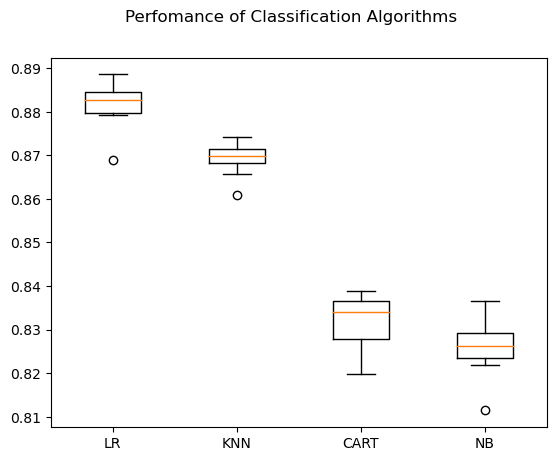

In [491]:
fig = plt.figure()
fig.suptitle('Perfomance of Classification Algorithms')
ax = fig.add_subplot(111)
plt.boxplot(results_c)
ax.set_xticklabels(names_c)
plt.show()

**Logistic regression is the best performing model.**

Among all algorithms, logistic regression achieved an accuracy of about 88%, suggesting a high level of strength of this model to classify the customer response given all the defined customer features.

## Test LR model on the test set

In [492]:
LR = LogisticRegression()
LR.fit(X_train, Y_train)

LogisticRegression()

## Evalute LR Model

In [493]:
predictions = LR.predict(X_test)

In [494]:
# Accuracy Score
print(accuracy_score(Y_test, predictions))

0.8876479044564857


Accuracy score is the percentage of correct predictions out of all predictions made. The LR algorithm achieves an accuracy of 89.08%, suggesting high level of strength of this model to classify the customer response given all the defined customer features.

[[8027    0]
 [1016    0]]


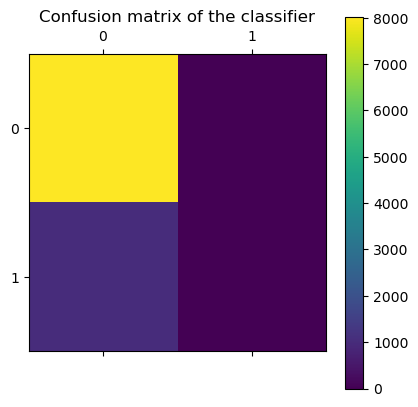

In [495]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import pylab as pl

print(confusion_matrix(Y_test, predictions))

cm = confusion_matrix(Y_test, predictions)
pl.matshow(cm)
pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

**However, the result of accuracy score can possibly yield misleading result if the data set is unbalanced, because the number of observations in different classes largely vary.**

A confusion matrix gives a detailed breakdown of prediction result and error types. Each cell in the matrix represents a combination of instances of the predicted response and the actual response. In the test set, the matrix proves that the algorithm performed well because most test results (7277 True Positive predictions) locate on the diagonal cells which represent correct predictions. 891 tests (False negative) predicted the bank’s client would subscribe to the term deposit but they actually did not.

**A problem revealed by this confusion matrix is that the dataset is highly unbalanced, with nearly all client actually decline to subscribe.** This infers that the accuracy score is biased, and further evaluation should be carried out to determine the accuracy of logistic regression model.

In [496]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      8027
           1       0.00      0.00      0.00      1016

    accuracy                           0.89      9043
   macro avg       0.44      0.50      0.47      9043
weighted avg       0.79      0.89      0.83      9043



Classification report shows the precision, recall, F1 and support scores for the LR classification model.
* Precision of 0 (the client said no) represents that for all instances predicted as no subscription, the percentage of clients that actually said no is 89%.
* Recall is the ability of a classifier to find all positive instances. Recall of 0 indicates that for all clients that actually said no, the model predicts 100% correctly that they would decline the offer.

In general, the report shows that **LR model has great predictive power to identify the customers who would not subscribe to the term deposit**. However, because of the limited number of clients accepting the term deposit, there is a **need for stratified sampling or rebalancing to deal with this structural weakness** before we conclude whether LR algorithm can accurately classify those who are more likely to subscribe.

# Part 6. Machine Learning: Regression

Regression analysis is carried out to complement the classification result and help the bank better predict campaign outcome based on customer statistics.

Since the duration of a phone call is positively correlated with the campaign outcome, it can serve as another indicator of the possibility of subscription. In this part, regression algorithms will be used to estimate the duration of a phone call, helping the bank better predict subscription rate.

## Prepare Data for Regression

In [498]:
dataset4 = dataset2.drop(['response_binary'],axis = 1)
dataset4['duration'] = dataset['duration']

### 6.1 Feature selection

The values of the first 19 columns, which contain customer statistics, are selected as features while the value of the last column, 'duration', is set as target.

In [499]:
array = dataset4.values
X = array[:,0:20]
Y = array[:,20]

### 6.2 Train/ test split

In [500]:
test_size= 0.20
seed = 10
X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size=test_size, random_state=seed)

## Compare regression algorithms

Six different regression algorithms (Linear Regression, Lasso, Ridge, ElasticNet, K Neighbors and Decision Tree) are run on the dataset and the best-performing one will be used to build the estimation model.

In [501]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [502]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('RIDGE', Ridge()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))

In [504]:
results_e2 = []
names_e2 = []

for name, model in models:
    # define how to split off validation data
    kfold = KFold(n_splits=10)

    # train the model
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results_e2.append(cv_results)
    names_e2.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.000000 (0.000000)
LASSO: -0.038559 (0.003641)
RIDGE: -0.000000 (0.000000)
EN: -0.038559 (0.003641)
KNN: -0.041653 (0.002803)
CART: 0.000000 (0.000000)


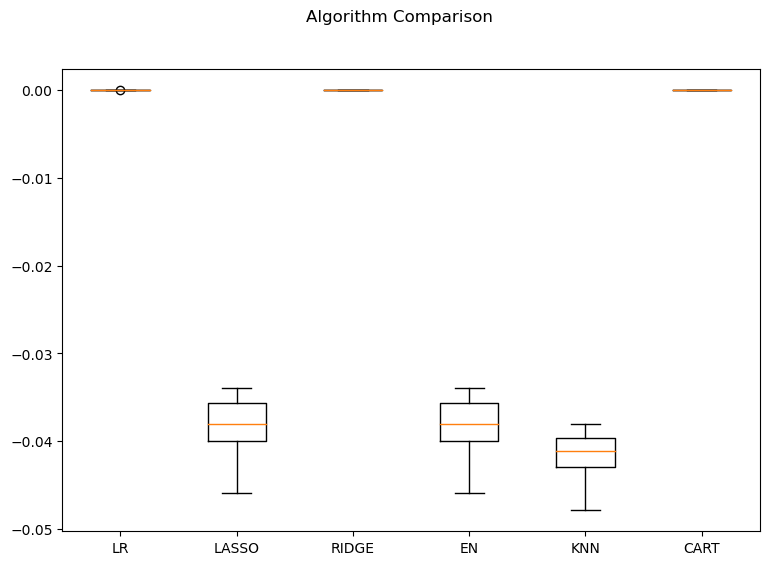

In [505]:
# Plot results
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.boxplot(results_e2)

fig.suptitle('Algorithm Comparison')
ax.set_xticklabels(names_e2)
plt.show()

**Ridge regression slightly outperforms other models.**

## Stardardize Data

In [506]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))

In [508]:
results_e2_normalized = []
names_e2_normalized = []

for name, model in pipelines:
    # define how to split off validation data
    kfold = KFold(n_splits=10)

    # train the model
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results_e2_normalized.append(cv_results)
    names_e2_normalized.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.000000 (0.000000)
ScaledLASSO: -0.038563 (0.003635)
ScaledRIDGE: -0.000000 (0.000000)
ScaledEN: -0.038563 (0.003635)
ScaledKNN: -0.001117 (0.000588)
ScaledCART: 0.000000 (0.000000)


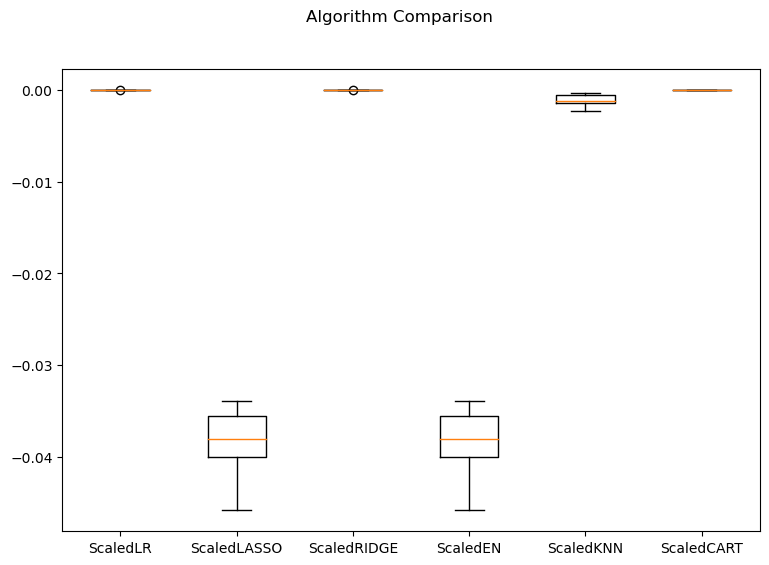

In [509]:
# Plot results
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.boxplot(results_e2_normalized)

fig.suptitle('Algorithm Comparison')
ax.set_xticklabels(names_e2_normalized)
plt.show()

**After standardization, ridge regression is still the best-performing model.**

## Test RIDGE model on the test set

In [510]:
ridge = Ridge()
ridge.fit(X_train, Y_train)
predicted_y = ridge.predict(X_test)

## Evaluate RIDGE Model

In [511]:
from sklearn.metrics import mean_squared_error
print('The MSE is', mean_squared_error(Y_test, predicted_y))

The MSE is 2.0760331705542483e-07


According to the previous analysis, observations on duration are extremely varied from 0.1 to 81.97 minutes in this dataset. Therefore, a 17.78 MSE testifies that ridge regression is a sound model in predicting the target variable and suggest that the bank can roughly estimate the duration of campaign calls of each client using their customer profiles such as age, job, and loans.

# Part 7. Conclusion & Recommendations

**The main objective of this project is to increase the effectiveness of the bank's telemarketing campaign, which was successfully met through data analysis,  visualization and analytical model building. A target customer profile was  established while classification and regression models were built to predict customers' response to the term deposit campaign.**

## Conclusion:

According to previous analysis, a target customer profile can be established. The most responsive customers possess these features:
* Feature 1: age < 30 or age > 60
* Feature 2: students or retired people
* Feature 3: a balance of more than 5000 euros

By applying logistic and ridge regression algorithms, classification and estimation model were successfully built. With these two models, the bank will be able to predict a customer's response to its telemarketing campaign before calling this customer. In this way, the bank can allocate more marketing efforts to the clients who are classified as highly likely to accept term deposits, and call less to those who are unlikely to make term deposits.

In addition, predicting duration before calling and adjusting marketing plan benefit both the bank and its clients. On the one hand, it will increase the efficiency of the bank’s telemarketing campaign, saving time and efforts. On the other hand, it prevents some clients from receiving undesirable advertisements, raising customer satisfaction. With the aid of logistic and ridge regression models, the bank can enter a virtuous cycle of effective marketing, more investments and happier customers.

## Recommendations

**1. More appropriate timing**

When implementing a marketing strategy, external factors, such as the time of calling, should also be carefully considered. The previous analysis points out that March, September, October and December had the highest success rates. Nevertheless, more data should be collected and analyzed to make sure that this seasonal effect is constant over time. If the trend has the potential to continue in the future, the bank should consider initiating its telemarketing campaign in fall and spring.

**2. Smarter marketing design**

By targeting the right customers, the bank will have more and more positive responses, and the classification algorithms would ultimately eliminate the imbalance in the original dataset. Hence, more accurate information will be presented to the bank for improving the subscriptions. Meanwhile, to increase the likelihood of subscription, the bank should re-evaluate the content and design of its current campaign, making it more appealing to its target customers.

**3. Better services provision**

With a more granular understanding of its customer base, the bank has the ability to provide better banking services.
For example, marital status and occupation reveal a customer's life stage while loan status indicates his/her overall risk profile. With this information, the bank can estimate when a customer might need to make an investment. In this way, the bank can better satisfy its customer demand by providing banking services for the right customer at the right time.